# Gensim word vector visualization of various word vectors

In [19]:
# Importing necessary libraries
import numpy as np  # Importing numpy for numerical operations
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
from sklearn.decomposition import PCA  # Importing PCA for dimensionality reduction
from gensim.test.utils import datapath, get_tmpfile  # Importing utility functions from gensim
from gensim.models import KeyedVectors  # Importing KeyedVectors for handling word vectors
from gensim.scripts.glove2word2vec import glove2word2vec  # Importing function to convert GloVe format to word2vec
import gensim.downloader as api  # Importing gensim downloader to load pre-trained models

For looking at word vectors, we'll use Gensim. Gensim isn't really a deep learning package. It's a package for word and text similarity modeling, which started with topic models and grew into SVD and neural word representations. But its efficient and scalable, and quite widely used.

We use GloVe word vectors. See [the Glove page](https://nlp.stanford.edu/projects/glove/) for details. Gensim has functionality to download a pre-trained model and load it. (We use the 100d vectors below as a mix between speed and smallness vs. quality. If you try out the 50d vectors, they basically work for similarity but clearly aren't as good for analogy problems. If you load the 300d vectors, they're even better than the 100d vectors.)

### GloVe Vectors Mathematical Details

GloVe is a model that creates word embeddings by capturing global statistical information from a corpus. The key idea behind GloVe is to leverage the global word-word co-occurrence matrix, which captures how frequently words appear together within a given context window.

#### 1. Co-occurrence Matrix

Let $X$ be the co-occurrence matrix where $X_{ij}$ represents the number of times word $j$ appears in the context of word $i$. The context can be defined in various ways, typically as a fixed window of words around the target word.

- $X_{ij}$: Number of times word $j$ occurs in the context of word $i$.
- $X_i = \sum_{k} X_{ik}$: Total number of times any word appears in the context of word $i$.

#### Example Corpus
Consider the following small corpus:
1. "I like deep learning"
2. "I like NLP"
3. "I enjoy flying"
​
#### Step 1: Vocabulary
Identify unique words in the corpus:
- Vocabulary: $ \{ \text{I, like, deep, learning, NLP, enjoy, flying} \} $
​
#### Step 2: Initialize Co-occurrence Matrix
Create a co-occurrence matrix $X$ where $X_{ij}$ represents the number of times word $j$ appears in the context of word $i$.
​
#### Step 3: Populate Co-occurrence Matrix
Using a context window of size 1:
​
- **Sentence 1**: "I like deep learning"
  - "I" (context: ["like"]): $X_{I, \text{like}} = 1$
  - "like" (context: ["I", "deep"]): $X_{\text{like}, I} = 1$, $X_{\text{like}, \text{deep}} = 1$
  - "deep" (context: ["like", "learning"]): $X_{\text{deep}, \text{like}} = 1$, $X_{\text{deep}, \text{learning}} = 1$
  - "learning" (context: ["deep"]): $X_{\text{learning}, \text{deep}} = 1$
​
- **Sentence 2**: "I like NLP"
  - "I" (context: ["like"]): $X_{I, \text{like}} = 2$ (increment by 1)
  - "like" (context: ["I", "NLP"]): $X_{\text{like}, I} = 2$ (increment by 1), $X_{\text{like}, \text{NLP}} = 1$
  - "NLP" (context: ["like"]): $X_{\text{NLP}, \text{like}} = 1$
​
- **Sentence 3**: "I enjoy flying"
  - "I" (context: ["enjoy"]): $X_{I, \text{enjoy}} = 1$
  - "enjoy" (context: ["I", "flying"]): $X_{\text{enjoy}, I} = 1$, $X_{\text{enjoy}, \text{flying}} = 1$
  - "flying" (context: ["enjoy"]): $X_{\text{flying}, \text{enjoy}} = 1$
​
#### Step 4: Co-occurrence Matrix
The final co-occurrence matrix $X$:
​
$$
\begin{array}{c|ccccccc}
 & \text{I} & \text{like} & \text{deep} & \text{learning} & \text{NLP} & \text{enjoy} & \text{flying} \\
\hline
\text{I} & 0 & 2 & 0 & 0 & 0 & 1 & 0 \\
\text{like} & 2 & 0 & 1 & 0 & 1 & 0 & 0 \\
\text{deep} & 0 & 1 & 0 & 1 & 0 & 0 & 0 \\
\text{learning} & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
\text{NLP} & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
\text{enjoy} & 1 & 0 & 0 & 0 & 0 & 0 & 1 \\
\text{flying} & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{array}
$$
​

#### 2. Objective Function

The objective of GloVe is to find word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence. Specifically, GloVe aims to minimize the following weighted least squares objective function:

$$
J = \sum_{i,j=1}^{V} f(X_{ij}) \left( w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log(X_{ij}) \right)^2
$$

where:
- $V$ is the size of the vocabulary.
- $w_i \in \mathbb{R}^d$: Word vector for the target word $i$.
- $\tilde{w}_j \in \mathbb{R}^d$: Word vector for the context word $j$.
- $b_i$: Bias term for the target word $i$.
- $\tilde{b}_j$: Bias term for the context word $j$.
- $f(X_{ij})$: Weighting function to balance the influence of different co-occurrences.

#### 3. Weighting Function

The weighting function $f(X_{ij})$ is designed to give less importance to very rare and very frequent co-occurrences:

$$
f(X_{ij}) = \begin{cases}
\left( \frac{X_{ij}}{X_{\max}} \right)^\alpha & \text{if } X_{ij} < X_{\max} \\
1 & \text{otherwise}
\end{cases}
$$

where:
- $X_{\max}$: Maximum number of co-occurrences to be considered.
- $\alpha$: A parameter typically set to 0.75.

#### 4. Vector Training

The training process involves solving the optimization problem to minimize the objective function $J$. This is usually done using stochastic gradient descent (SGD) or its variants. The gradient updates for the word vectors and biases are derived from the objective function:

For word vector $w_i$:
$$
\frac{\partial J}{\partial w_i} = \sum_{j=1}^{V} f(X_{ij}) \left( w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log(X_{ij}) \right) \tilde{w}_j
$$

For context vector $\tilde{w}_j$:
$$
\frac{\partial J}{\partial \tilde{w}_j} = \sum_{i=1}^{V} f(X_{ij}) \left( w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log(X_{ij}) \right) w_i
$$

For bias $b_i$:
$$
\frac{\partial J}{\partial b_i} = \sum_{j=1}^{V} f(X_{ij}) \left( w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log(X_{ij}) \right)
$$

For context bias $\tilde{b}_j$:
$$
\frac{\partial J}{\partial \tilde{b}_j} = \sum_{i=1}^{V} f(X_{ij}) \left( w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log(X_{ij}) \right)
$$

#### 5. Final Word Vectors

After training, we obtain two sets of word vectors: $w_i$ for target words and $\tilde{w}_j$ for context words. Often, the final word vector representation for a word is taken as the sum of the two vectors:

$$
v_i = w_i + \tilde{w}_i
$$

This combined vector captures both the word's context when it appears as a target word and when it appears as a context word.

### Summary

GloVe vectors are learned by leveraging the global word-word co-occurrence matrix and optimizing a weighted least squares objective function. The resulting word embeddings capture semantic relationships between words and are useful for various natural language processing tasks.


In [20]:
# Load GloVe word vectors
# Gensim has functionality to download a pre-trained model and load it. We use the 100d vectors below.
model = api.load('glove-wiki-gigaword-100')  # Loading pre-trained GloVe vectors with 100 dimensions

In [46]:
# Check some examples of word vectors
# print(len(model['bread']))
print(model['bread'])  # Print the word vector for the word 'bread'


100
[-0.66146    0.94335   -0.72214    0.17403   -0.42524    0.36303
  1.0135    -0.14802    0.25817   -0.20326   -0.64338    0.16632
  0.61518    1.397     -0.094506   0.0041843 -0.18976   -0.55421
 -0.39371   -0.22501   -0.34643    0.32076    0.34395   -0.7034
  0.23932    0.69951   -0.16461   -0.31819   -0.34034   -0.44906
 -0.069667   0.35348    0.17498   -0.95057   -0.2209     1.0647
  0.23231    0.32569    0.47662   -1.1206     0.28168   -0.75172
 -0.54654   -0.66337    0.34804   -0.69058   -0.77092   -0.40167
 -0.069351  -0.049238  -0.39351    0.16735   -0.14512    1.0083
 -1.0608    -0.87314   -0.29339    0.68278    0.61634   -0.088844
  0.88094    0.099809  -0.27161   -0.58026    0.50364   -0.93814
  0.67576   -0.43124   -0.10517   -1.2404    -0.74353    0.28637
  0.29012    0.89377    0.67406    0.86422   -0.30693   -0.14718
  0.078353   0.74013    0.32658   -0.052579  -1.1665     0.87079
 -0.69402   -0.75977   -0.37164   -0.11887    0.18551    0.041883
  0.59352    0.30519  

In [22]:
print(model['croissant'])  # Print the word vector for the word 'croissant'

[-0.25144    0.52157   -0.75452    0.28039   -0.31388    0.274
  1.1971    -0.10519    0.82544   -0.33398   -0.21417    0.22216
  0.14982    0.47384    0.41984    0.69397   -0.25999   -0.44414
  0.58296   -0.30851   -0.076455   0.33468    0.28055   -0.99012
  0.30349    0.39128    0.031526  -0.095395  -0.004745  -0.81347
  0.27869   -0.1812     0.14632   -0.42186    0.13857    1.139
  0.14925   -0.051459   0.37875   -0.2613     0.011081  -0.28881
 -0.38662   -0.3135    -0.1954     0.19248   -0.52995   -0.40674
 -0.25159    0.06272   -0.32724    0.28374   -0.2155    -0.061832
 -0.50134    0.0093959  0.30715    0.3873    -0.74554   -0.45947
  0.40032   -0.1378    -0.26968   -0.3946    -0.64876   -0.47149
 -0.085536   0.092795  -0.034018  -0.61906    0.19123    0.20563
  0.29056   -0.010908   0.15313    0.33144    0.33806    0.061708
  0.20785    0.65348   -0.053222   0.18589    0.32647   -0.11923
  0.42008   -0.26931    0.025489   0.0036535  0.1327    -0.22763
  0.07564    0.55773    0.2

# Explanation of `model.most_similar`

## Parameters

1. **positive**: List of words (or tuples of words and weights) that contribute positively.
   - Example: `['king', 'woman']` or `[('king', 0.8), ('queen', 0.2)]`.

2. **negative**: List of words (or tuples of words and weights) that contribute negatively.
   - Example: `['man']` or `[('man', 1.0)]`.

3. **topn**: The number of top-n similar words to return. Default is 10.

## Return

- Returns a list of tuples. Each tuple contains a word and its similarity score.

## Mathematical Explanation

The `model.most_similar` function finds words that are most similar to a given combination of words by performing vector arithmetic on the word embeddings.

Given the word vectors $ \mathbf{v}_\text{king} $, $ \mathbf{v}_\text{man} $, and $ \mathbf{v}_\text{woman} $, the function computes a new vector $ \mathbf{v} $ as follows:

$$
\mathbf{v} = \mathbf{v}_\text{king} + \mathbf{v}_\text{woman} - \mathbf{v}_\text{man}
$$

This new vector $ \mathbf{v} $ is then used to find the top-n words whose vectors are closest to $ \mathbf{v} $ in terms of cosine similarity.

### Cosine Similarity

Cosine similarity between two vectors $ \mathbf{a} $ and $ \mathbf{b} $ is defined as:

$$
\text{cosine\_similarity}(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{\| \mathbf{a} \| \| \mathbf{b} \|}
$$

Where:
- $ \mathbf{a} \cdot \mathbf{b} $ is the dot product of vectors $ \mathbf{a} $ and $ \mathbf{b} $.
- $ \| \mathbf{a} \| $ is the Euclidean norm (magnitude) of vector $ \mathbf{a} $.
- $ \| \mathbf{b} \| $ is the Euclidean norm (magnitude) of vector $ \mathbf{b} $.

## Summary

The `model.most_similar` function performs vector arithmetic on word embeddings to find the resultant vector, then calculates the cosine similarity between this vector and all word vectors in the vocabulary. It ranks the words based on their similarity scores and returns the top-n most similar words. This process allows the model to capture semantic relationships and solve analogy tasks effectively.


In [23]:
model.most_similar('obama')

[('barack', 0.937216579914093),
 ('bush', 0.927285373210907),
 ('clinton', 0.896000325679779),
 ('mccain', 0.8875633478164673),
 ('gore', 0.8000321388244629),
 ('hillary', 0.7933662533760071),
 ('dole', 0.7851964831352234),
 ('rodham', 0.7518897652626038),
 ('romney', 0.7488929629325867),
 ('kerry', 0.7472624182701111)]

In [24]:
model.most_similar('banana')

[('coconut', 0.7097253203392029),
 ('mango', 0.7054824829101562),
 ('bananas', 0.6887733340263367),
 ('potato', 0.6629636287689209),
 ('pineapple', 0.6534532308578491),
 ('fruit', 0.6519854664802551),
 ('peanut', 0.6420575976371765),
 ('pecan', 0.6349173188209534),
 ('cashew', 0.6294420957565308),
 ('papaya', 0.6246591210365295)]

In [25]:
model.most_similar(negative='banana')

[('shunichi', 0.49618104100227356),
 ('ieronymos', 0.4736502170562744),
 ('pengrowth', 0.4668096601963043),
 ('höss', 0.4636845588684082),
 ('damaskinos', 0.4617849290370941),
 ('yadin', 0.4617374837398529),
 ('hundertwasser', 0.4588957726955414),
 ('ncpa', 0.4577339291572571),
 ('maccormac', 0.4566109776496887),
 ('rothfeld', 0.4523947238922119)]

In [26]:
# Analogies
result = model.most_similar(positive=['woman', 'king'], negative=['man'])  # Perform analogy: woman is to king as man is to ?
print("{}: {:.4f}".format(*result[0]))  # Print the top result of the analogy with its similarity score

queen: 0.7699


In [27]:
# Define a function for analogies
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])  # Perform analogy based on provided words
    return result[0][0]  # Return the top result

In [28]:
analogy('pencil', 'sketching', 'camera')

'photographing'

In [29]:
analogy('japan', 'japanese', 'australia')

'australian'

In [30]:
analogy('obama', 'clinton', 'reagan')

'nixon'

In [31]:
analogy('tall', 'tallest', 'long')

'longest'

In [32]:
analogy('good', 'fantastic', 'bad')

'terrible'

# Explanation of `model.doesnt_match`

## Parameters

- **list_of_words**: A list of words among which one word does not fit the pattern or context. The goal is to identify and return this word.

## Return

- Returns the word that does not match the context or pattern of the other words in the list.

## Mathematical Explanation

The `model.doesnt_match` function identifies the word in the list that does not fit the semantic context or pattern of the other words. This is achieved by analyzing the word vectors and calculating the overall coherence of each word with the others.

Given a list of word vectors $ \{\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_n\} $, the function computes the average vector $ \mathbf{v}_{\text{mean}} $ as follows:

$$
\mathbf{v}_{\text{mean}} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{v}_i
$$

Then, for each word vector $ \mathbf{v}_i $, the function calculates the cosine similarity between $ \mathbf{v}_i $ and $ \mathbf{v}_{\text{mean}} $:

$$
\text{cosine\_similarity}(\mathbf{v}_i, \mathbf{v}_{\text{mean}}) = \frac{\mathbf{v}_i \cdot \mathbf{v}_{\text{mean}}}{\| \mathbf{v}_i \| \| \mathbf{v}_{\text{mean}} \|}
$$

The word with the lowest cosine similarity to the mean vector $ \mathbf{v}_{\text{mean}} $ is considered the word that doesn't match the context, as it is the furthest away in the semantic space.

## Summary

The `model.doesnt_match` function analyzes the semantic coherence of a list of words by computing the average word vector and comparing the cosine similarity of each word vector to the average. The word with the lowest similarity score is identified as the one that does not fit the context or pattern of the other words. This method helps in recognizing outliers in a given set of semantically related words.


In [33]:
# Word out of context
print(model.doesnt_match("breakfast cereal dinner lunch".split()))  # Find the word that doesn't fit the context

cereal


# Explanation of PCA (Principal Component Analysis) for Word Vector Visualization

## Parameters

- **model**: A trained word embedding model, such as those provided by GloVe or Word2Vec.
- **words** (optional): A list of specific words to visualize. If not provided, a random sample of words will be selected.
- **sample** (optional): The number of words to sample from the model's vocabulary if `words` is not provided. Default is 0, meaning all words in the model's vocabulary will be used.

## Return

- A 2D scatter plot visualizing the selected word vectors in two dimensions using PCA.

## Mathematical Explanation

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space. In the context of word vectors, PCA is used to project high-dimensional word vectors into a 2D space for visualization purposes.

Given a matrix of word vectors $ \mathbf{X} $ with shape $ (n, d) $, where $ n $ is the number of words and $ d $ is the dimensionality of the word vectors, PCA works as follows:

1. **Mean Centering**: Subtract the mean of each dimension from the corresponding dimension of all word vectors to center the data around the origin.
   
   $$
   \mathbf{X}_{\text{centered}} = \mathbf{X} - \mathbf{\mu}
   $$

   where $ \mathbf{\mu} $ is the mean vector of $ \mathbf{X} $.

2. **Covariance Matrix**: Compute the covariance matrix $ \mathbf{C} $ of the centered word vectors.
   
   $$
   \mathbf{C} = \frac{1}{n} \mathbf{X}_{\text{centered}}^\top \mathbf{X}_{\text{centered}}
   $$

3. **Eigen Decomposition**: Perform eigen decomposition on the covariance matrix to obtain eigenvalues and eigenvectors.
   
   $$
   \mathbf{C} = \mathbf{V} \mathbf{\Lambda} \mathbf{V}^\top
   $$

   where $ \mathbf{V} $ is the matrix of eigenvectors and $ \mathbf{\Lambda} $ is the diagonal matrix of eigenvalues.

4. **Select Top Components**: Select the top $ k $ eigenvectors corresponding to the largest eigenvalues to form the transformation matrix $ \mathbf{W} $.
   
   $$
   \mathbf{W} = [\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_k]
   $$

5. **Project Data**: Transform the original word vectors into the lower-dimensional space using the transformation matrix.
   
   $$
   \mathbf{X}_{\text{reduced}} = \mathbf{X}_{\text{centered}} \mathbf{W}
   $$

For 2D visualization, $ k $ is typically set to 2, resulting in a 2D scatter plot of the word vectors.

## Summary

PCA is used to reduce the dimensionality of high-dimensional word vectors for visualization. By projecting the word vectors into a 2D space, PCA allows us to visualize the relationships and similarities between words in a way that is easy to interpret. The key steps involve mean centering, computing the covariance matrix, performing eigen decomposition, selecting top components, and projecting the data into the lower-dimensional space.


In [34]:
# PCA for visualization
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:  # If no specific words are provided
        if sample > 0:  # If a sample size is specified
            words = np.random.choice(list(model.index_to_key), sample)  # Randomly select words from the model's vocabulary
        else:
            words = [word for word in model.index_to_key]  # Use all words in the model's vocabulary
    word_vectors = np.array([model[w] for w in words])  # Create an array of word vectors for the selected words
    twodim = PCA().fit_transform(word_vectors)[:,:2]  # Apply PCA to reduce dimensionality to 2D
    plt.figure(figsize=(6,6))  # Create a new figure for plotting
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')  # Plot the word vectors in 2D space
    for word, (x,y) in zip(words, twodim):  # Annotate each point with the corresponding word
        plt.text(x+0.05, y+0.05, word)

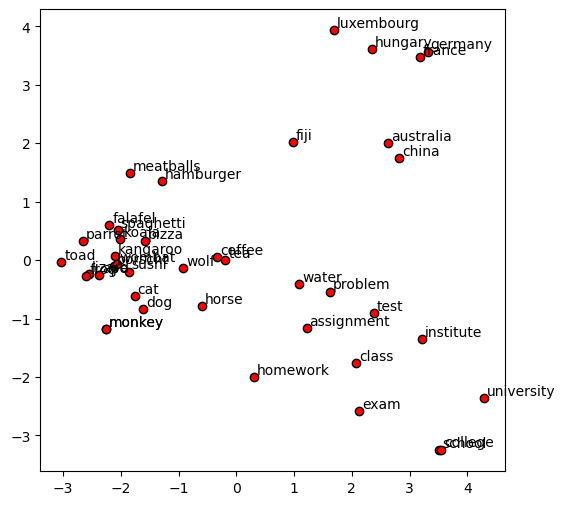

In [35]:
display_pca_scatterplot(model,
                        ['coffee', 'tea', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

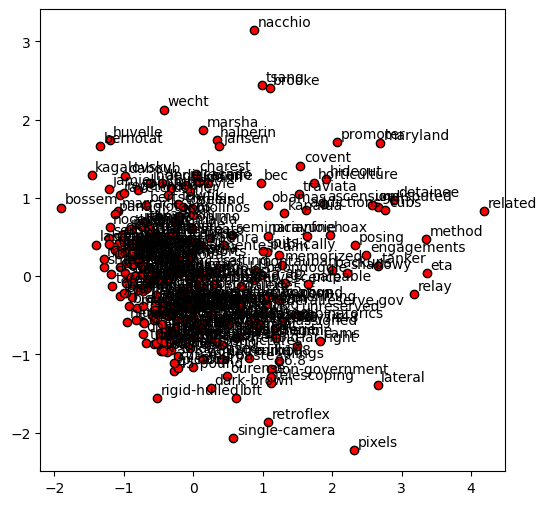

In [36]:
# Visualize a random sample of 300 words
display_pca_scatterplot(model, sample=300)  # Visualize a random sample of 300 words from the model's vocabulary

Some Word Vectors for Arabic:
- https://github.com/bakrianoo/aravec/
- https://github.com/tarekeldeeb/GloVe-Arabic

If you feel adventurous, go ahead and load one of the models in gensim and try some analogy or related NLP task.

### Task 1: Exploring Word Similarities
### Load the GloVe model and explore the words similar to "apple", "computer", and "university".
### For each word, find the top 5 most similar words and display them.


In [39]:
# Function to find and display most similar words
def display_similar_words(word, top_n=5):
    similar_words = model.most_similar(word, topn=top_n)
    print(f"Top {top_n} words similar to '{word}':")
    for w, similarity in similar_words:
        print(f"  {w}: {similarity:.4f}")
    print("\n")

words_to_check = ["apple", "computer", "university"]
for word in words_to_check:
    display_similar_words(word)


Top 5 words similar to 'apple':
  microsoft: 0.7449
  ibm: 0.6822
  intel: 0.6778
  software: 0.6775
  dell: 0.6741


Top 5 words similar to 'computer':
  computers: 0.8752
  software: 0.8373
  technology: 0.7642
  pc: 0.7366
  hardware: 0.7290


Top 5 words similar to 'university':
  college: 0.8294
  harvard: 0.8156
  yale: 0.8114
  professor: 0.8104
  graduate: 0.7993




### Task 2: Creating Analogies
### Using the loaded GloVe model, create analogies for the following pairs:
### 1. teacher : school :: doctor : ?
### 2. water : drink :: food : ?
### 3. Paris : France :: Tokyo : ?


In [42]:
# Function to find and display word analogies
def display_analogy(word1, word2, word3):
    result = model.most_similar(positive=[word1, word3], negative=[word2])[0]
    print(f"'{word1}' is to '{word2}' as '{word3}' is to '{result[0]}'")

analogies = [
    ("teacher", "school", "doctor"),
    ("water", "drink", "food"),
    ("paris", "france", "tokyo")
]

for word1, word2, word3 in analogies:
    display_analogy(word1, word2, word3)


'teacher' is to 'school' as 'doctor' is to 'nurse'
'water' is to 'drink' as 'food' is to 'supplies'
'paris' is to 'france' as 'tokyo' is to 'osaka'


### Task 3: Out-of-context Words
### Find the word that doesn't match the context in each of the following lists:
### 1. ["red", "blue", "green", "apple"]
### 2. ["cat", "dog", "fish", "car"]
### 3. ["breakfast", "lunch", "dinner", "banana"]


In [43]:
# Function to find and display out-of-context words
def display_doesnt_match(words):
    out_of_context_word = model.doesnt_match(words)
    print(f"In the list {words}, '{out_of_context_word}' does not match the context.")

lists_to_check = [
    ["red", "blue", "green", "apple"],
    ["cat", "dog", "fish", "car"],
    ["breakfast", "lunch", "dinner", "banana"]
]

for word_list in lists_to_check:
    display_doesnt_match(word_list)


In the list ['red', 'blue', 'green', 'apple'], 'apple' does not match the context.
In the list ['cat', 'dog', 'fish', 'car'], 'car' does not match the context.
In the list ['breakfast', 'lunch', 'dinner', 'banana'], 'banana' does not match the context.


### Task 4: Visualizing Word Vectors
### Visualize the word vectors for the following groups of words using PCA:
### 1. ["king", "queen", "man", "woman", "prince", "princess"]
### 2. ["car", "bicycle", "airplane", "train", "boat"]
### 3. ["dog", "cat", "fish", "bird", "hamster"]


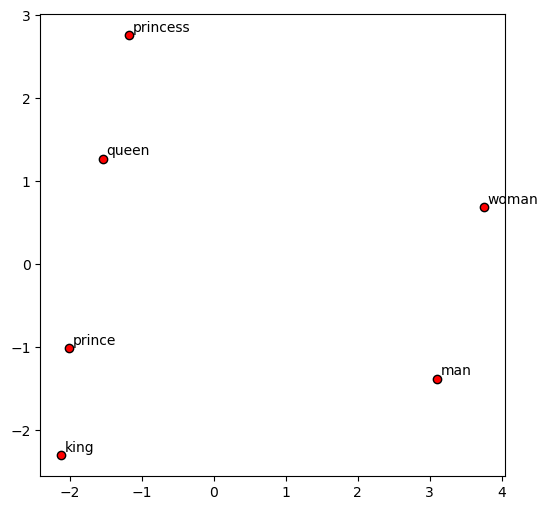

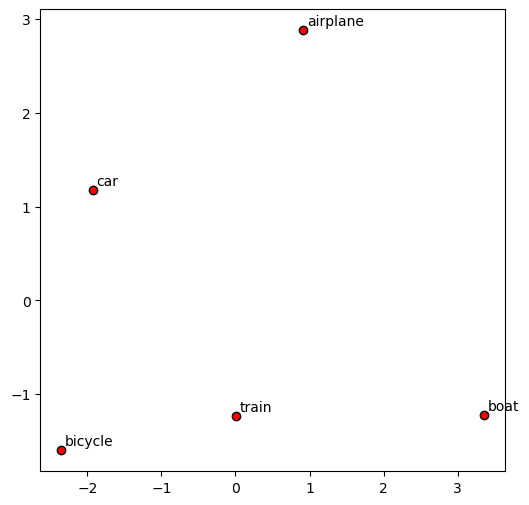

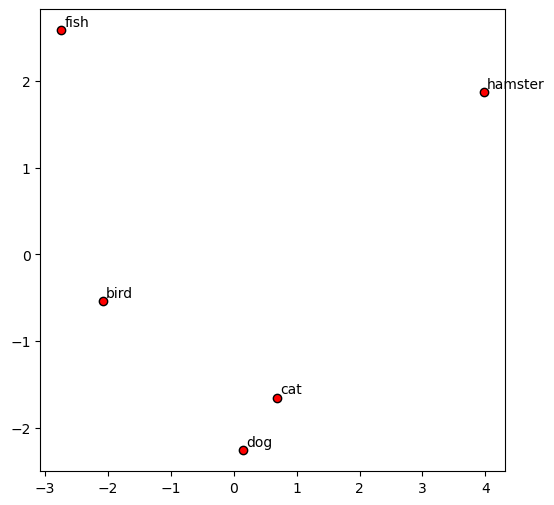

In [44]:
# Function to display PCA scatter plot of word vectors
def display_pca_scatterplot(model, words=None, sample=0):
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.index_to_key), sample)
        else:
            words = [word for word in model.index_to_key]
    
    word_vectors = np.array([model[word] for word in words])
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.show()

word_groups = [
    ["king", "queen", "man", "woman", "prince", "princess"],
    ["car", "bicycle", "airplane", "train", "boat"],
    ["dog", "cat", "fish", "bird", "hamster"]
]

for group in word_groups:
    display_pca_scatterplot(model, group)


### Task 5: Custom Word Analogy Function
### Write a custom function to find analogies using pairs of words. Use the function to find analogies for:
### 1. ("doctor", "hospital"), ("teacher", "school")
### 2. ("sun", "day"), ("moon", "night")
### 3. ("keyboard", "typing"), ("brush", "painting")


In [45]:
# Modified analogy function
def custom_analogy(pair1, pair2):
    word1, word2 = pair1
    word3, _ = pair2
    result = model.most_similar(positive=[word2, word3], negative=[word1])[0]
    return result[0]

# Using the custom analogy function
analogies = [
    (("doctor", "hospital"), ("teacher", "school")),
    (("sun", "day"), ("moon", "night")),
    (("keyboard", "typing"), ("brush", "painting"))
]

for (pair1, pair2) in analogies:
    word = custom_analogy(pair1, pair2)
    print(f"'{pair1[1]}' is to '{pair1[0]}' as '{pair2[1]}' is to '{word}'")


'hospital' is to 'doctor' as 'school' is to 'school'
'day' is to 'sun' as 'night' is to 'days'
'typing' is to 'keyboard' as 'painting' is to 'brushing'
